# Diffusion equation parallelized

## The 1D case. NOT IN PARALLEL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%%px
nx = 2*1000
dx = 0.1
nt = 100000
dt = 0.004
D = 1.0 # diffusion constant
x = np.arange(nx)*dx

# initial condition
sigma0 = 20*dx
c = np.exp(-(x-nx*dx/2)**2/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)

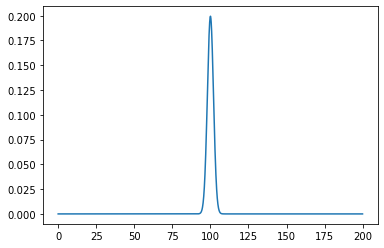

In [2]:
fig, ax = plt.subplots()
ax.plot(x, c)

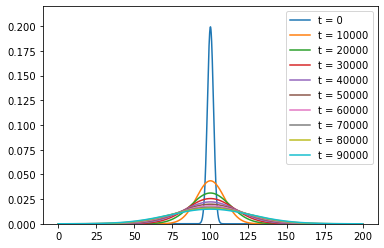

In [3]:
fig, ax = plt.subplots()
# The loop over timestps
for t in np.arange(nt):
    #
    cleft = np.roll(c,shift=1).copy()
    crght = np.roll(c,shift=-1).copy()
    ccent = c.copy()
    c = c + D*dt/dx**2*(cleft -2.*ccent+crght)
    #ax.set_title('rank ${}$'.format(rank))
    if t%10000==0:
        #ax.set_xlim(0, nx*dx)
        ax.set_ylim(0, 0.22)
        ax.plot(x, c, label='t = {}'.format(t))
        ax.legend()

## The 2D case. NOT IN PARALLEL

In [4]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D 
#import matplotlib.animation as animation
# 
nx = 4*250
ny = 4*250
c = np.zeros((nx,ny))
dx = dy = 0.1
x = np.arange(nx)*dx
y = np.arange(ny)*dy
X, Y = np.meshgrid(x,y)
# Initial condition
sigma0 = 10*dx
c = np.exp(-((X-nx*dx/2)**2+(Y-ny*dy/2)**2)/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)
# Time discretization
nt = 100000
nevery = 10000
dt = 0.001
D = 1.0 # diffusion constant

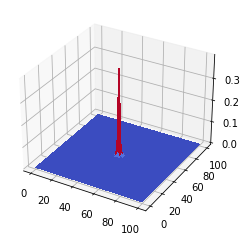

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plot = ax.plot_surface(X, Y, c, cmap=cm.coolwarm,linewidth=0, antialiased=False)

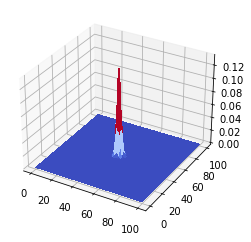

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
#surf = ax.plot_surface(X, Y, c, cmap=cm.coolwarm,linewidth=0, antialiased=False)
# The frames
#fps = 10 # frames per second
#frn = nt//nevery
#zarray = np.zeros((nx, ny, frn))
# The loop over timestps
#i = 0
for t in np.arange(1000):
    #
    cup = np.roll(c,shift=(1,0),axis=(0,1)).copy()
    cdown = np.roll(c,shift=(-1,0),axis=(0,1)).copy()
    cleft = np.roll(c,shift=(0,1),axis=(0,1)).copy()
    crght = np.roll(c,shift=(0,-1),axis=(0,1)).copy()
    ccent = c.copy()
    c = c + D*dt/dx**2*(cleft+cdown -4.*ccent+crght+cup)
#
plot.remove()
plot = ax.plot_surface(X, Y, c, cmap=cm.coolwarm,linewidth=0, antialiased=False)

## Parallel

In [7]:
client.shutdown()

NameError: name 'client' is not defined

In [1]:
import ipyparallel as ipp
#
NCPU = 4
cluster = ipp.Cluster(engines="mpi", n=NCPU)
client = cluster.start_and_connect_sync()
#
client.ids

ModuleNotFoundError: No module named 'ipyparallel'

In [ ]:
%%px
#client.wait_for_engines(6)
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
#
# Start Intracommunicator and get what is out there i.t.o. size and rank
# Note that all these variables are known to all ranks where size is equal
# for all and rank is specific to the rank number of the process.
#
comm = MPI.COMM_WORLD      # start the communicator assign to comm
size = comm.Get_size()     # get the size and assign to size
rank = comm.Get_rank()     # get the rank and assign to rank
#
# This is just for checking if it worked and should give sth. like this:
#[stdout:3] Rank/Size 3/16
#
#[stdout:5] Rank/Size 5/16
#
#[stdout:10] Rank/Size 10/16
#
#[stdout:0] Rank/Size 0/16
#
#[stdout:1] Rank/Size 1/16
#
print('Rank/Size {}/{}'.format(rank,size))    

In [ ]:
%px %matplotlib inline

### 1D

In [ ]:
%%px
# 
nx = 1000
dx = 0.1
nt = 100000
dt = 0.001
D = 1 # diffusion constant

### Domain decomposition

In [ ]:
%%px
# Domain decomposition: set up domain boundaries
nx1 = rank*nx//size
nx2 = (rank+1)*nx//size

print('{}, Domain boundaries: {}-{}'.format(rank, nx1, nx2))

# We include one additional cell at the boundaries for communication purposes
x = np.arange(nx1-1, nx2+1)*dx

### Initial condition: Gaussian concentration profile initially

In [ ]:
%%px
sigma0 = 20*dx
c = np.exp(-(x-nx*dx/2)**2/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)

plt.title('rank ${}$'.format(rank))
plt.xlim(0, nx*dx)
plt.ylim(0, 0.3)
plt.plot(x, c)

### Gather all data on rank 0 and plot

In [ ]:
%%px
x_full_range = np.arange(nx)*dx
c_full_range = np.zeros(nx)
comm.Gather(c[1:-1], c_full_range, root=0)
if rank == 0:
    fig, ax = plt.subplots()
    ax.plot(x_full_range, c_full_range, '-')

### Propagate in time. Gather during progation so we can plot the evolution of the concentration profile

In [ ]:
%%px
#
x_full_range = np.arange(nx)*dx
c_full_range = np.zeros(nx)
if rank == 0: fig, ax = plt.subplots()
#
for t in range(nt+1):
    # Send to right, receive from left
    comm.Sendrecv(c[-2:-1], (rank+1)%size, recvbuf=c[:1], source=(rank-1)%size)
    # Send to left, receive from right
    comm.Sendrecv(c[1:2], (rank-1)%size, recvbuf=c[-1:], source=(rank+1)%size)
    if t % (nt//5) == 0:
        comm.Gather(c[1:-1], c_full_range, root=0)
        if rank == 0:
            ax.plot(x_full_range, c_full_range, label='t = {}'.format(t))
    d2c_dx2 = (np.roll(c, 1)-2*c+np.roll(c, -1))/(dx**2)
    c += D*d2c_dx2*dt
if rank == 0: ax.legend(loc='best')

## 2D

In [ ]:
%%px
dx = 0.1
nt = 100000
dt = 0.001
D = 1 # diffusion constant

## 2D Domain decomposition

In [ ]:
%%px
#
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
#
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
#
# Let us take a square simulation domain that can be divided 
# by the number of cores and results in a square subdomain 
NX = 400
NY = 400
#
#print('NX = {} NY = {}, and sqrt(NX*NY) = {}'.format(NX,NY,np.sqrt(NX*NY)))
#print('NX/NY = {} and NY/NX = {}\n'.format(NX/NY,NY/NX))
#
if NX < NY:
    sectsX=int(np.floor(np.sqrt(size*NX/NY)))
    sectsY=int(np.floor(size/sectsX))
    print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
    print('How do the fractions look like?')
    print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
elif NX > NY:
    sectsY=int(np.floor(np.sqrt(size*NY/NX)))
    sectsX=int(np.floor(size/sectsY))
    print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
    print('How do the fractions look like?')
    print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
elif NX==NY:
    sectsY=int(np.floor(np.sqrt(size)))
    sectsX=int(size/sectsY)
    if rank == 0: print('In the case of equal size we divide the processes as {} and {}'.format(sectsX,sectsY))
#
#print('Rank {}/{} is alive.'.format(rank, size))
#
sectsX=int(np.floor(np.sqrt(size)))
sectsY=int(size//sectsX)
#
#sectsX=int(sys.argv[3])
#sectsY=int(sys.argv[4])
nxsub = NX//sectsX+2
nysub = NY//sectsY+2
boundary_k=[False,False,False,False]
cartcomm=comm.Create_cart(dims=[sectsX,sectsY],periods=[True,True],reorder=False)
rcoords = cartcomm.Get_coords(rank)
#
# where to receive from and where send to 
sR,dR = cartcomm.Shift(1,1)
sL,dL = cartcomm.Shift(1,-1)
sU,dU = cartcomm.Shift(0,1)
sD,dD = cartcomm.Shift(0,-1)
sd = np.array([sR,dR,sL,dL,sU,dU,sD,dD], dtype = int)

## Analysis of the domain

In [ ]:
%%px
allrcoords = comm.gather(rcoords,root = 0)
allDestSourBuf = np.zeros(size*8, dtype = int)
comm.Gather(sd, allDestSourBuf, root = 0)
#
#print(sd)
if rank == 0:
    print(' ')
    cartarray = np.ones((sectsY,sectsX))
    allDestSour = np.array(allDestSourBuf).reshape((size,8))
    for i in np.arange(size):
        cartarray[allrcoords[i][0],allrcoords[i][1]] = i
        print('Rank {} all destinations and sources {}'.format(i,allDestSour[i,:]))
        sR,dR,sL,dL,sU,dU,sD,dD = allDestSour[i]
        print('Rank {} is at {}'.format(i,allrcoords[i]))
        print('sour/dest right {} {}.'.format(sR,dR))
        print('sour/dest left  {} {}.'.format(sL,dL))  
        print('sour/dest up    {} {}.'.format(sU,dU))
        print('sour/dest down  {} {}.'.format(sD,dD))
        #print('[stdout:',i,']',allDestSour[i])
    print('')
    print(cartarray)

## Initial conditions 2D

In [ ]:
%%px
#nx = 1600
dx = 0.1
nt = 10000
dt = 0.001
D = 1 # diffusion constant
# Define the gridpoints
x = np.arange(rcoords[0]*NX//sectsX,(rcoords[0]+1)*NX//sectsX)*dx
y = np.arange(rcoords[1]*NY//sectsX,(rcoords[1]+1)*NY//sectsY)*dx
X,Y = np.meshgrid(x,y)
#
sigma0 = 30*dx
c = np.zeros((nxsub,nysub))
c[1:-1,1:-1] = np.exp(-((X-NX/2*dx)**2+(Y-NY/2*dx)**2)/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)

In [ ]:
%%px
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

In [ ]:
%%px
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, c[1:-1,1:-1], cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [ ]:
%%px
#
c_full_range = np.zeros((NX*NY))
comm.Gather(c[1:-1,1:-1].reshape((nxsub-2)*(nysub-2)), c_full_range, root = 0)
rcoords_x = comm.gather(rcoords[0], root=0)
rcoords_y = comm.gather(rcoords[1], root=0)
if rank == 0:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#
    X0, Y0 = np.meshgrid(np.arange(NX),np.arange(NY))
    xy = np.array([rcoords_x,rcoords_y]).T
    c_plot = np.zeros((NX,NY))
    #
    for i in np.arange(sectsX):
        for j in np.arange(sectsY):
            k = i*sectsX+j
            xlo = NX//sectsX*xy[k,1]
            xhi = NX//sectsX*(xy[k,1]+1)
            ylo = NY//sectsY*xy[k,0]
            yhi = NY//sectsY*(xy[k,0]+1)
            clo = k*NX*NY//(sectsX*sectsY)
            chi = (k+1)*NX*NY//(sectsX*sectsY)
            #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
            #print((xhi-xlo)*(yhi-ylo),chi-clo)
            c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//sectsX,NY//sectsY)
#            
    ax.plot_surface(X0, Y0, c_plot, cmap=cm.coolwarm,linewidth=0, antialiased=False)
#

## Communicate between subdomains

In [ ]:
%%px
# Communication between subdomains
def Communicate(c,cartcomm,sd):
    recvbuf = np.zeros(c[:,1].shape[0])
    sR,dR,sL,dL,sU,dU,sD,dD = sd
    # Send to right which is destination rigth (dR) and receive from left which is source right (sR)
    # print(rank,'Right, source',sR,'destination',dR)
    sendbuf = c[:,-2].copy() # Send the second last column to dR
    cartcomm.Sendrecv(sendbuf, dR, recvbuf = recvbuf, source = sR)
    c[:,0] = recvbuf # received into the 0th column from sR
    # Send to left and receive from right
    #print(rank,'Left, source',sL,'destination',dL)
    sendbuf = c[:,1].copy()
    cartcomm.Sendrecv(sendbuf, dL, recvbuf = recvbuf, source = sL)
    c[:,-1] = recvbuf
    # Send to up and receive from down
    #print(rank,'Up, source',sU,'destination',dU)
    sendbuf = c[1,:].copy()
    cartcomm.Sendrecv(sendbuf, dU, recvbuf = recvbuf, source = sU)
    c[-1,:] = recvbuf
    # Send to down and receive from up
    #print(rank,'Down, source',sD,'destination',dD)
    sendbuf = c[-2,:].copy()
    cartcomm.Sendrecv(sendbuf, dD, recvbuf = recvbuf, source = sD)
    c[0,:]=recvbuf
#
    return c

In [ ]:
%%px
print(sd)

In [ ]:
%%px
# Communication between subdomains
def Communicate(c,cartcomm,sd):
    recvbuf = np.zeros(c[:,1].shape[0])
    sR,dR,sL,dL,sU,dU,sD,dD = sd
    # Send to up and receive from down
    #print(rank,'Up, source',sU,'destination',dU)
    cartcomm.Sendrecv(c[1,:],dU,recvbuf=recvbuf,source=sU)
    c[-1,:] = recvbuf
    # Send to down and receive from up
    #print(rank,'Down, source',sD,'destination',dD)
    cartcomm.Sendrecv(c[-2,:],dD,recvbuf=recvbuf,source=sD)
    c[0,:]=recvbuf
    # Send to right and receive from left
    #print(rank,'Right, source',sR,'destination',dR)
    sendbuf = c[:,-2].copy()
    cartcomm.Sendrecv(sendbuf,dR,recvbuf=recvbuf,source=sR)
    c[:,0] = recvbuf
    # Send to left and receive from right
    #print(rank,'Left, source',sL,'destination',dL)
    sendbuf = c[:,1].copy()
    cartcomm.Sendrecv(sendbuf,dL,recvbuf=recvbuf,source=sL)
    c[:,-1] = recvbuf
#
    return c

## Integrate forward in time

In [ ]:
%%px
# The time stepping loop
for t in np.arange(100):
    # First we need a communication step
    c = Communicate(c,cartcomm,sd)
    # Then we do a timestep forward
    cup = np.roll(c,shift=(1,0),axis=(0,1)).copy()
    cdown = np.roll(c,shift=(-1,0),axis=(0,1)).copy()
    cleft = np.roll(c,shift=(0,1),axis=(0,1)).copy()
    crght = np.roll(c,shift=(0,-1),axis=(0,1)).copy()
    ccent = c.copy()
    c = c + D*dt/dx**2*(cleft+cdown -4.*ccent+crght+cup)

In [ ]:
# Then let's plot
#
c_full_range = np.zeros((NX*NY))
comm.Gather(c[1:-1,1:-1].reshape((nxsub-2)*(nysub-2)), c_full_range, root = 0)
rcoords_x = comm.gather(rcoords[0], root=0)
rcoords_y = comm.gather(rcoords[1], root=0)
if rank == 0:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#
    X0, Y0 = np.meshgrid(np.arange(NX),np.arange(NY))
    xy = np.array([rcoords_x,rcoords_y]).T
    c_plot = np.zeros((NX,NY))
    #
    for i in np.arange(sectsX):
        for j in np.arange(sectsY):
            k = i*sectsX+j
            xlo = NX//sectsX*xy[k,1]
            xhi = NX//sectsX*(xy[k,1]+1)
            ylo = NY//sectsY*xy[k,0]
            yhi = NY//sectsY*(xy[k,0]+1)
            clo = k*NX*NY//(sectsX*sectsY)
            chi = (k+1)*NX*NY//(sectsX*sectsY)
            #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
            #print((xhi-xlo)*(yhi-ylo),chi-clo)
            c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//sectsX,NY//sectsY)
#            
    ax.plot_surface(X0, Y0, c_plot, cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [ ]:
%%px
if rank==0:
    for i in np.arange(sectsX):
        for j in np.arange(sectsY):
            k = i*sectsX+j
            xlo = NX//sectsX*xy[k,1]
            xhi = NX//sectsX*(xy[k,1]+1)
            ylo = NY//sectsY*xy[k,0]
            yhi = NY//sectsY*(xy[k,0]+1)
            clo = k*NX*NY//(sectsX*sectsY)
            chi = (k+1)*NX*NY//(sectsX*sectsY)
            print(' ')
            print('k = {}, xlo = {}, xhi = {}'.format(k,xlo,xhi))
            print('k = {}, ylo = {}, yhi = {}'.format(k,ylo,yhi))
            print('k = {}, clo = {}, chi = {}'.format(k,clo,chi))